INPUT: Folder/scenario name\
OUTPUT: CSV file with mean reward, stdev, and metadata. Plot of training curve.

Plot Learning Curves

In [2]:
import json
import os
import numpy as np
import pandas as pd

sanity_check = False

root_dir = f'../sacred/confidentiality_medium/'

def buid_result_df_eval(root_dir):
    # Create empty dataframe
    df = pd.DataFrame()

    # Iterate through each folder
    for root, dirs, files in os.walk(root_dir):
        for file in files:

            # Check for eval directory name if running in mode
            if "eval" not in os.path.join(root, file):
                continue

            # Check if info.json and config.json exist
            if 'info.json' in files and 'config.json' in files:

                # Read the info file
                with open(os.path.join(root, 'info.json')) as info_f:
                    data = json.load(info_f)

                # Read the config file
                with open(os.path.join(root, 'config.json')) as config_f:
                    config = json.load(config_f)

                # Extract return_mean and return_mean_T values from the json
                return_mean = [sample['value'] for sample in data['test_return_mean']]
                return_std = [sample['value'] for sample in data['test_return_std']]

                # Put the values in a numpy array
                info_arr = np.array([return_mean, return_std]).T

                # Convert the numpy array to a pandas dataframe
                df_info = pd.DataFrame(info_arr, columns=['return_mean', 'return_stdev'])

                # Loop through the config file and add the variables as columns
                for key, value in config.items():
                    df_info[key] = value
                    # Add variables from sub dict
                    if key == 'env_args':
                        for arg_key, arg_val in value.items():
                            df_info[arg_key] = arg_val
                    df_info['path'] = root

                # Append file info to dataset
                df = pd.concat([df, df_info])
    return df


df = buid_result_df_eval(root_dir)

if df.empty:
    print("No data met the criteria.")
else:
    # rename mac to algorithm
    df.loc[df['mac']=='n_mac', 'mac'] = 'qmix'
    df.loc[df['mac']=='basic_mac', 'mac'] = 'iql'
    df.loc[df['learner']=='ppo_learner', 'mac'] = 'ppo'
    df.loc[(df['map_name'] == 'confidentiality_hard_single') & (df['mac'] == 'iql'), 'mac'] = 'dqn'
    df.rename(columns={'mac': 'algorithm'}, inplace=True)

    # rename spec config
    df.loc[df['no_obs']==True, 'wrapper_type'] = 'no_obs'

    df.to_csv(f'../datasets/temp.csv')
    print(df.groupby([ 'algorithm', 'map_name', 'wrapper_type'])['seed'].nunique())

algorithm  map_name                wrapper_type
iql        confidentiality_medium  table           48
qmix       confidentiality_medium  table           48
Name: seed, dtype: int64


In [2]:
import pandas as pd
df = pd.read_csv('../datasets/temp.csv')

Save tabular results

In [3]:
df_mean = df.groupby(['name'])[['return_mean', 'return_stdev']].mean().reset_index()
df_cv = df_mean.groupby(['name'])[['return_mean', 'return_stdev']].mean().reset_index()

df.to_csv('../datasets/hyperparam_eval.csv')
df_mean.to_csv('../datasets/hyperparam_eval_mean.csv')
df_cv.to_csv('../datasets/hyperparam_eval_cv.csv')

In [14]:
df_iql = df[df['algorithm']=='iql']
df_qmix = df[df['algorithm']=='qmix']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'eval_iql_batch_size=128_buffer_size=5000_lr=0.005_td_lambda=0.6'),
  Text(1, 0, 'eval_iql_batch_size=128_buffer_size=5000_lr=0.01_td_lambda=0.6'),
  Text(2, 0, 'eval_iql_batch_size=256_buffer_size=10000_lr=0.005_td_lambda=0.6'),
  Text(3, 0, 'eval_iql_batch_size=128_buffer_size=10000_lr=0.005_td_lambda=0.6'),
  Text(4, 0, 'eval_iql_batch_size=128_buffer_size=10000_lr=0.005_td_lambda=0.0'),
  Text(5, 0, 'eval_iql_batch_size=128_buffer_size=10000_lr=0.01_td_lambda=0.6'),
  Text(6, 0, 'eval_iql_batch_size=256_buffer_size=5000_lr=0.005_td_lambda=0.6'),
  Text(7, 0, 'eval_iql_batch_size=256_buffer_size=10000_lr=0.01_td_lambda=0.6'),
  Text(8, 0, 'eval_iql_batch_size=256_buffer_size=5000_lr=0.01_td_lambda=0.6'),
  Text(9, 0, 'eval_iql_batch_size=128_buffer_size=5000_lr=0.005_td_lambda=0.0'),
  Text(10, 0, 'eval_qmix_batch_size=128_buf

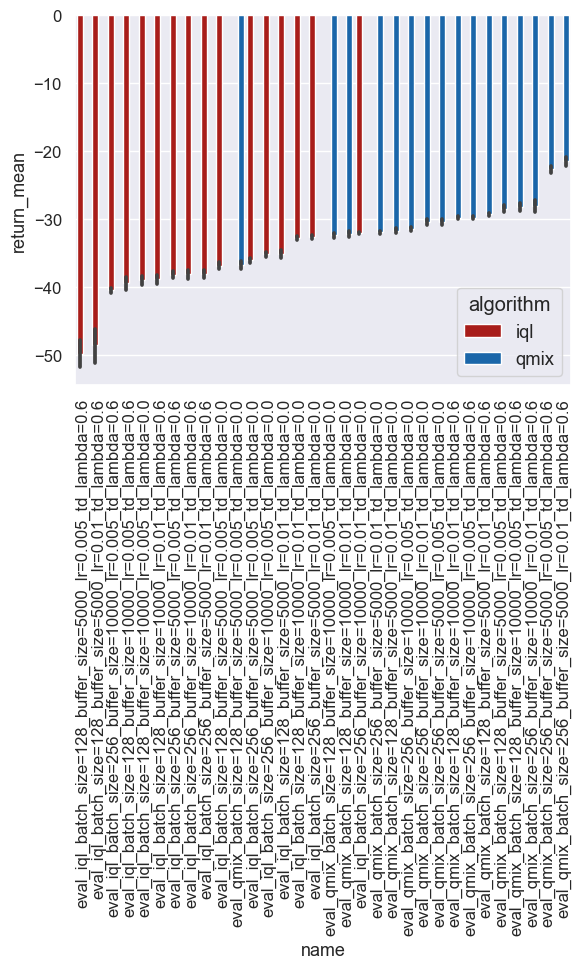

In [17]:


sort_order = df_cv.sort_values('return_mean')['name']
g = sns.barplot(
    data=df, x='name', y='return_mean',
    hue='algorithm',
    order=sort_order,
    palette=['#BF0603',  '#0267C1', '#136F63', '#9A5B8B', ], 
)

plt.xticks(rotation=90)